<a href="https://colab.research.google.com/github/hvhq/classificationp1/blob/master/WorkingLab03_MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab03: MLP

---
MSSV: 18120361

Họ và tên: Huỳnh Văn Hiền

## Import

In [1]:
%matplotlib inline
#import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import _pickle as cPickle

# ignore warning ...
import warnings
import math
warnings.filterwarnings('ignore')

## Định nghĩa các hàm
**Hàm đọc bộ dữ liệu CIFAR-10**

In [2]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = cPickle.load(fo, encoding='latin1')
    return dict
def read_data(containing_dir, num_train_batchs):
    # Read training data
    train_X_batchs = []
    train_Y_batchs = []
    for batch_idx in range(num_train_batchs):
        batch = unpickle(containing_dir + '/data_batch_' + str(batch_idx + 1))
        train_X_batchs.append(batch['data'])
        train_Y_batchs.append(np.array(batch['labels']).reshape(-1, 1))
    train_X = np.vstack(train_X_batchs)
    train_X = train_X / 255. # Normalize to [0, 1]
    train_X = np.hstack([np.ones((len(train_X), 1)), train_X])
    train_Y = np.vstack(train_Y_batchs)
    
    # Read test data
    batch = unpickle(containing_dir + '/test_batch')
    test_X = batch['data']
    test_X = test_X / 255. # Normalize to [0, 1]
    test_X = np.hstack([np.ones((len(test_X), 1)), test_X])
    test_Y = np.array(batch['labels']).reshape(-1, 1)
    
    return (train_X, train_Y, test_X, test_Y)

**Hàm tính output và gradient của Neural Net**

Ở đây, ta dùng hàm kích hoạt sigmoid ở các tầng ẩn, và hàm softmax ở tầng cuối.
Ta có:

$$ h=w^TX $$

$$\text{Sigmoid Activation: } z= \sigma \left(h\right)= \dfrac{1}{1+e^{-h}}$$

$$\text{Cross-entrophy loss: } J(w)=-\left({ylog(z)+(1-y)log(1-z)}\right)$$

$$\text{Chain rule: } \dfrac{\partial J(w)}{\partial w}=\dfrac{\partial J(w)}{\partial z} \dfrac{\partial z}{\partial h}\dfrac{\partial h}{\partial w}  $$

$$\dfrac{\partial J(w)}{\partial z}=-\left(\dfrac{y}{z}-\dfrac{1-y}{1-z}\right)=\dfrac{z-y}{z(1-z)}$$

$$\dfrac{\partial z}{\partial h}=z(1-z)$$

$$\dfrac{\partial h}{\partial w}=X$$

$$\dfrac{\partial J(w)}{\partial w}=X^T(z-y)$$

**Hàm cost và gradient tầng sigmoid:**
$$J(w)=\dfrac{1}{N} \sum_{n=1}^N-\left({ylog(z)+(1-y)log(1-z)}\right)  $$
$$\text{Gradient: } \dfrac{\partial J(w)}{\partial w}=\dfrac{1}{N}X^T(z-y)$$  

Hàm softmax (C là số lớp): 
$$h(z_i)=\dfrac{e^{z_i}}{\sum_{j=1}^{C}e^{z_j}}$$
**Hàm cost tầng softmax lúc này là:**
$$J(w)=\dfrac{1}{N} \sum_{n=1}^N \sum_{k=1}^K -(y_n)_k log \left(h(x_n)_k\right)  $$

Sử dụng kỹ thuật one-hot-encoding mã hóa tập label y, ta có:
 $$\text{với } (y_n)_k=    \begin{align}
        \begin{cases}
             0 \text { nếu } y_n\neq k\\
             1 \text { nếu } y_n= k\\
        \end{cases}
    \end{align} $$
lúc này số lớp sẽ là 2 hay C=2:

$$h(z_1)=\dfrac{e^{z_1}}{\sum_{j=1}^{2}e^{z_j}}$$

$$h(z_1)=\dfrac{e^{z_1}}{e^{z_1}+e^{z_2}}$$

$$h(z_1)=\dfrac{1}{1+e^{z_2-z_1}}$$

=> Đây chính là hàm sigmoid. Hơn nữa mặc dù có 2 output softmax vẫn có thể rút gọn thành 1 output vì tổng 2 outputs luôn bằng 1

**Do đó hàm cost của tầng softmax và tầng sigmoid là tương tự nhau** 

**=> Gradient của tầng softmax cũng tương tự của tầng sigmoid**

In [3]:
 
def sigmoid(x):
    '''
    Computes sigmoid function for each element of array S.
    '''
    return 1 / (1 + np.exp(-x))
 
 
 
def gradient_sigmoid(As, Ws ,mb_X,delta, i):
    '''
    Computes gradient vector for sigmoid layer.
    '''
    #add virtual input (for bias)
    mb_X = np.append(mb_X, [[1] for it in range(len(mb_X))], axis=1)
    #number of sample
    num_mb = len(As[0])
    #output of this layer-input of next layer
    A = As[i + 1]
    #weight of next layer-delete the bias
    Ws_i1_shape = np.delete(Ws[i + 1], len(Ws[i + 1])-1, axis=0)
    #error
    error = np.matmul(delta, np.transpose(Ws_i1_shape))
    #delta error
    deltaer = np.multiply(np.multiply(A, 1-A), error)
    #delta weight
    deltaw = np.zeros((mb_X.shape[1], A.shape[1]))

    #for every sample of input
    for i_mbi in range(mb_X.shape[0]):
        #add grad to sum grad
        deltaw = np.add(deltaw, np.matmul(np.transpose(mb_X[i_mbi:i_mbi+1]), deltaer[i_mbi:i_mbi+1]))
    #divide sum grad by number of sample
    deltaw = 1 / num_mb * deltaw

    #delta=deltaer
    #grad = deltaw
    return deltaer, deltaw
 
 
def softmax(S):
    '''
    Computes softmax function for each row of array S.
    '''
    A = np.exp(S)
    A /=A.sum(axis=1, keepdims=True)
 
    return A
 
def gradient_softmax(As,mb_X,mb_Y):
    '''
    Computes gradient vector for softmaz layer
    '''
    #add virtual input (for bias)
    mb_X = np.append(mb_X, [[1] for it in range(len(mb_X))], axis=1)
    
    #number of sample
    num_mb = len(As[0])

    #processing layer: last layer
    ilayer = len(As) - 1
    A = As[ilayer]

    #error
    error = np.subtract(mb_Y, A)
    #delta_error
    deltaer = np.multiply(np.multiply(A, 1-A), error)
    #delta_weight/gradient
    deltaw = np.zeros((mb_X.shape[1], A.shape[1]))

    #for every sample of input
    for i_mbi in range(mb_X.shape[0]):
        #add the grad to sum grad
        deltaw = np.add(deltaw, np.matmul(np.transpose(mb_X[i_mbi:i_mbi+1]), deltaer[i_mbi:i_mbi+1]))
    #divide by number of sample
    deltaw = 1 / num_mb * deltaw

    #delta=deltaer
    #grad = deltaw
    return deltaer, deltaw
 
 
def compute_nnet_outputs(Ws, X, need_all_layer_outputs):
    '''
    Computes the outputs of Neural Net by forward propagating X through the net.
    '''
    #delete the bias col before add it to As
    X = np.delete(X, len(X[0]) - 1, axis = 1)

    #create a bias col for latter insertion
    bias = [[1] for i in range(X.shape[0])]
    
    #not yet any layer output added
    As = []
    #first, processing layer = input layer
    A = X
    #add input to the nnet_output, view it as a output of the first layer: input layer
    As.append(A)
    #add bias, after add input to the nnet_output, because the input have bias but the output do not
    A = np.append(A, bias, axis = 1)

    for ilayer in range(Ws.shape[0]):
        if ilayer != Ws.shape[0] - 1:
            #hidden layer
            A = sigmoid(np.matmul(A, Ws[ilayer]))
        else:
            #softmax layer
            A = softmax(np.matmul(A, Ws[ilayer]))

        #add the calculated layer output to the nnet_output
        As.append(A)
        A = np.append(A, bias, axis = 1)

    if need_all_layer_outputs:
        return As
    else:
        return As[Ws.shape[0]]
 
    #if need_all_layer_outputs:
    #    return As
    #else:
    #    return A

**Các hàm khởi tạo tham số**

In [4]:

def compute_layer_sizes(X, Y, hid_layer_sizes):
    num_classes = len(np.unique(Y)) # Num classes
    layer_sizes = [X.shape[1] - 1] + hid_layer_sizes + [num_classes]
    print('Layer Sizes: ',layer_sizes)
    return layer_sizes


def one_hot_encoding(Y, num_classes):
    num_classes = len(np.unique(Y)) # Num classes
    one_hot_Y = np.zeros((len(Y), num_classes))
    one_hot_Y[np.arange(len(Y)), Y.reshape(-1)] = 1
    return one_hot_Y


def init_weight_matrix(X,Y,layer_sizes):
    #fix random for same result when init weight matrix
    np.random.seed(0) 
    Ws = np.array([np.random.randn(layer_sizes[i]+1 , layer_sizes[i + 1]) / np.sqrt(layer_sizes[i]+1) 
          for i in range(len(layer_sizes) - 1)]) # Init Ws
    print('Weight matrix shape: ',Ws[0].shape,Ws[1].shape)
    return Ws




**Hàm huấn luyện Neural net**

In [5]:

def updateWeights(Ws,As,mb_X, mb_Y,  learning_rate):
    
    #update weights for softmax layer
    smlayer = len(Ws) - 1
    delta, grad = gradient_softmax(As, As[smlayer], mb_Y)
    Ws[smlayer] = np.add(Ws[smlayer], learning_rate * grad)

    #update weights for hidden layer
    for ilayer in range(smlayer - 1, -1, -1):
        delta, grad = gradient_sigmoid(As, Ws, As[ilayer], delta, ilayer)
        Ws[ilayer] = np.add(Ws[ilayer], learning_rate * grad)
    
    return Ws

def train_nnet(X, Y, hid_layer_sizes, mb_size, learning_rate, max_epoch):
    
    #get layer sizes:
    layer_sizes = compute_layer_sizes(X, Y, hid_layer_sizes)

    
    # Prepare for training
    Ws=init_weight_matrix(X,Y,layer_sizes)
    one_hot_Y=one_hot_encoding(Y,layer_sizes[-1])
    
    costs = [] # To save costs during training
    errs = [] # To save mean binary errors during training
    N = len(X) # Num training examples
    rnd_idxs = list(range(N)) # Random indexes    

    # Train
    for epoch in list(range(max_epoch)):
        #shuffle index
        np.random.shuffle(rnd_idxs)
        for start_idx in list(range(0, N, mb_size)):
            # Get minibach
            mb_X = X[rnd_idxs[start_idx:start_idx+mb_size]]
            mb_Y = one_hot_Y[rnd_idxs[start_idx:start_idx+mb_size]]
            
            # Forward-prop
            As = compute_nnet_outputs(Ws, mb_X, True)
            
            # Back-prop; on the way, compute each layer's gradient and update its W
            Ws=updateWeights(Ws,As,mb_X,mb_Y,learning_rate)   
        
        # Compute training info, save it, and print it
        A = compute_nnet_outputs(Ws, X, False)
        cost = np.mean(-np.sum(one_hot_Y * np.log(A), axis=1))
        err = np.mean(np.argmax(A, axis=1) != Y.squeeze()) * 100
        costs.append(cost)
        errs.append(err)
        print ('Epoch %d, cost %.3f, err %.3f%%' %(epoch, cost, err))
            
    return Ws, costs, errs

## Chạy

**1.** Đọc dữ liệu (cần đặt thư mục chứa dữ liệu `cifar-10-batches-py` vào cùng thư mục chứa file notebook này)

In [6]:
tarFileDir = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
!wget "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
!tar -xvzf cifar-10-python.tar.gz

--2020-12-24 22:02:36--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.3’

cifar-10-python.tar 100%[===================>] 162.60M  72.5MB/s    in 2.2s    

2020-12-24 22:02:39 (72.5 MB/s) - ‘cifar-10-python.tar.gz.3’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [7]:
num_train_batchs = 3 
train_X, train_Y, test_X, test_Y = read_data('cifar-10-batches-py', num_train_batchs)
print ('train_X.shape = %s, train_Y.shape = %s' %(train_X.shape, train_Y.shape))
print ('test_X.shape  = %s, test_Y.shape  = %s' %(test_X.shape, test_Y.shape))

train_X.shape = (30000, 3073), train_Y.shape = (30000, 1)
test_X.shape  = (10000, 3073), test_Y.shape  = (10000, 1)


**2.** Để thấy được sự ảnh hưởng của số lượng nơ-ron ẩn, ta sẽ lần lượt huấn luyện Neural Net với `hid_layer_sizes = [50]`, `[100]`, và `[200]` (cố định `mb_size = 32`, `learning_rate = 0.01`, `max_epoch = 200`)

In [8]:
W_0, costs_0, errs_0 = train_nnet(train_X, train_Y, [50], 32, 0.01, 10)

Layer Sizes:  [3072, 50, 10]
Weight matrix shape:  (3073, 50) (51, 10)
Epoch 0, cost 2.271, err 86.007%
Epoch 1, cost 2.241, err 79.683%
Epoch 2, cost 2.214, err 77.570%
Epoch 3, cost 2.192, err 76.037%
Epoch 4, cost 2.171, err 75.503%
Epoch 5, cost 2.152, err 74.227%
Epoch 6, cost 2.135, err 73.600%
Epoch 7, cost 2.120, err 72.853%
Epoch 8, cost 2.104, err 72.427%
Epoch 9, cost 2.090, err 71.500%


In [9]:
W_1, costs_1, errs_1 = train_nnet(train_X, train_Y, [100], 32, 0.01, 10)

Layer Sizes:  [3072, 100, 10]
Weight matrix shape:  (3073, 100) (101, 10)
Epoch 0, cost 2.262, err 81.957%
Epoch 1, cost 2.226, err 81.120%
Epoch 2, cost 2.196, err 78.033%
Epoch 3, cost 2.171, err 76.173%
Epoch 4, cost 2.148, err 74.797%
Epoch 5, cost 2.128, err 73.223%
Epoch 6, cost 2.111, err 72.420%
Epoch 7, cost 2.095, err 72.430%
Epoch 8, cost 2.081, err 71.383%
Epoch 9, cost 2.069, err 71.483%


In [10]:
W_2, costs_2, errs_2 = train_nnet(train_X, train_Y, [200], 32, 0.01, 10)

Layer Sizes:  [3072, 200, 10]
Weight matrix shape:  (3073, 200) (201, 10)
Epoch 0, cost 2.257, err 79.893%
Epoch 1, cost 2.218, err 76.820%
Epoch 2, cost 2.187, err 75.530%
Epoch 3, cost 2.160, err 73.773%
Epoch 4, cost 2.140, err 73.063%
Epoch 5, cost 2.122, err 72.653%
Epoch 6, cost 2.107, err 71.513%
Epoch 7, cost 2.091, err 71.487%
Epoch 8, cost 2.088, err 71.807%
Epoch 9, cost 2.073, err 71.060%


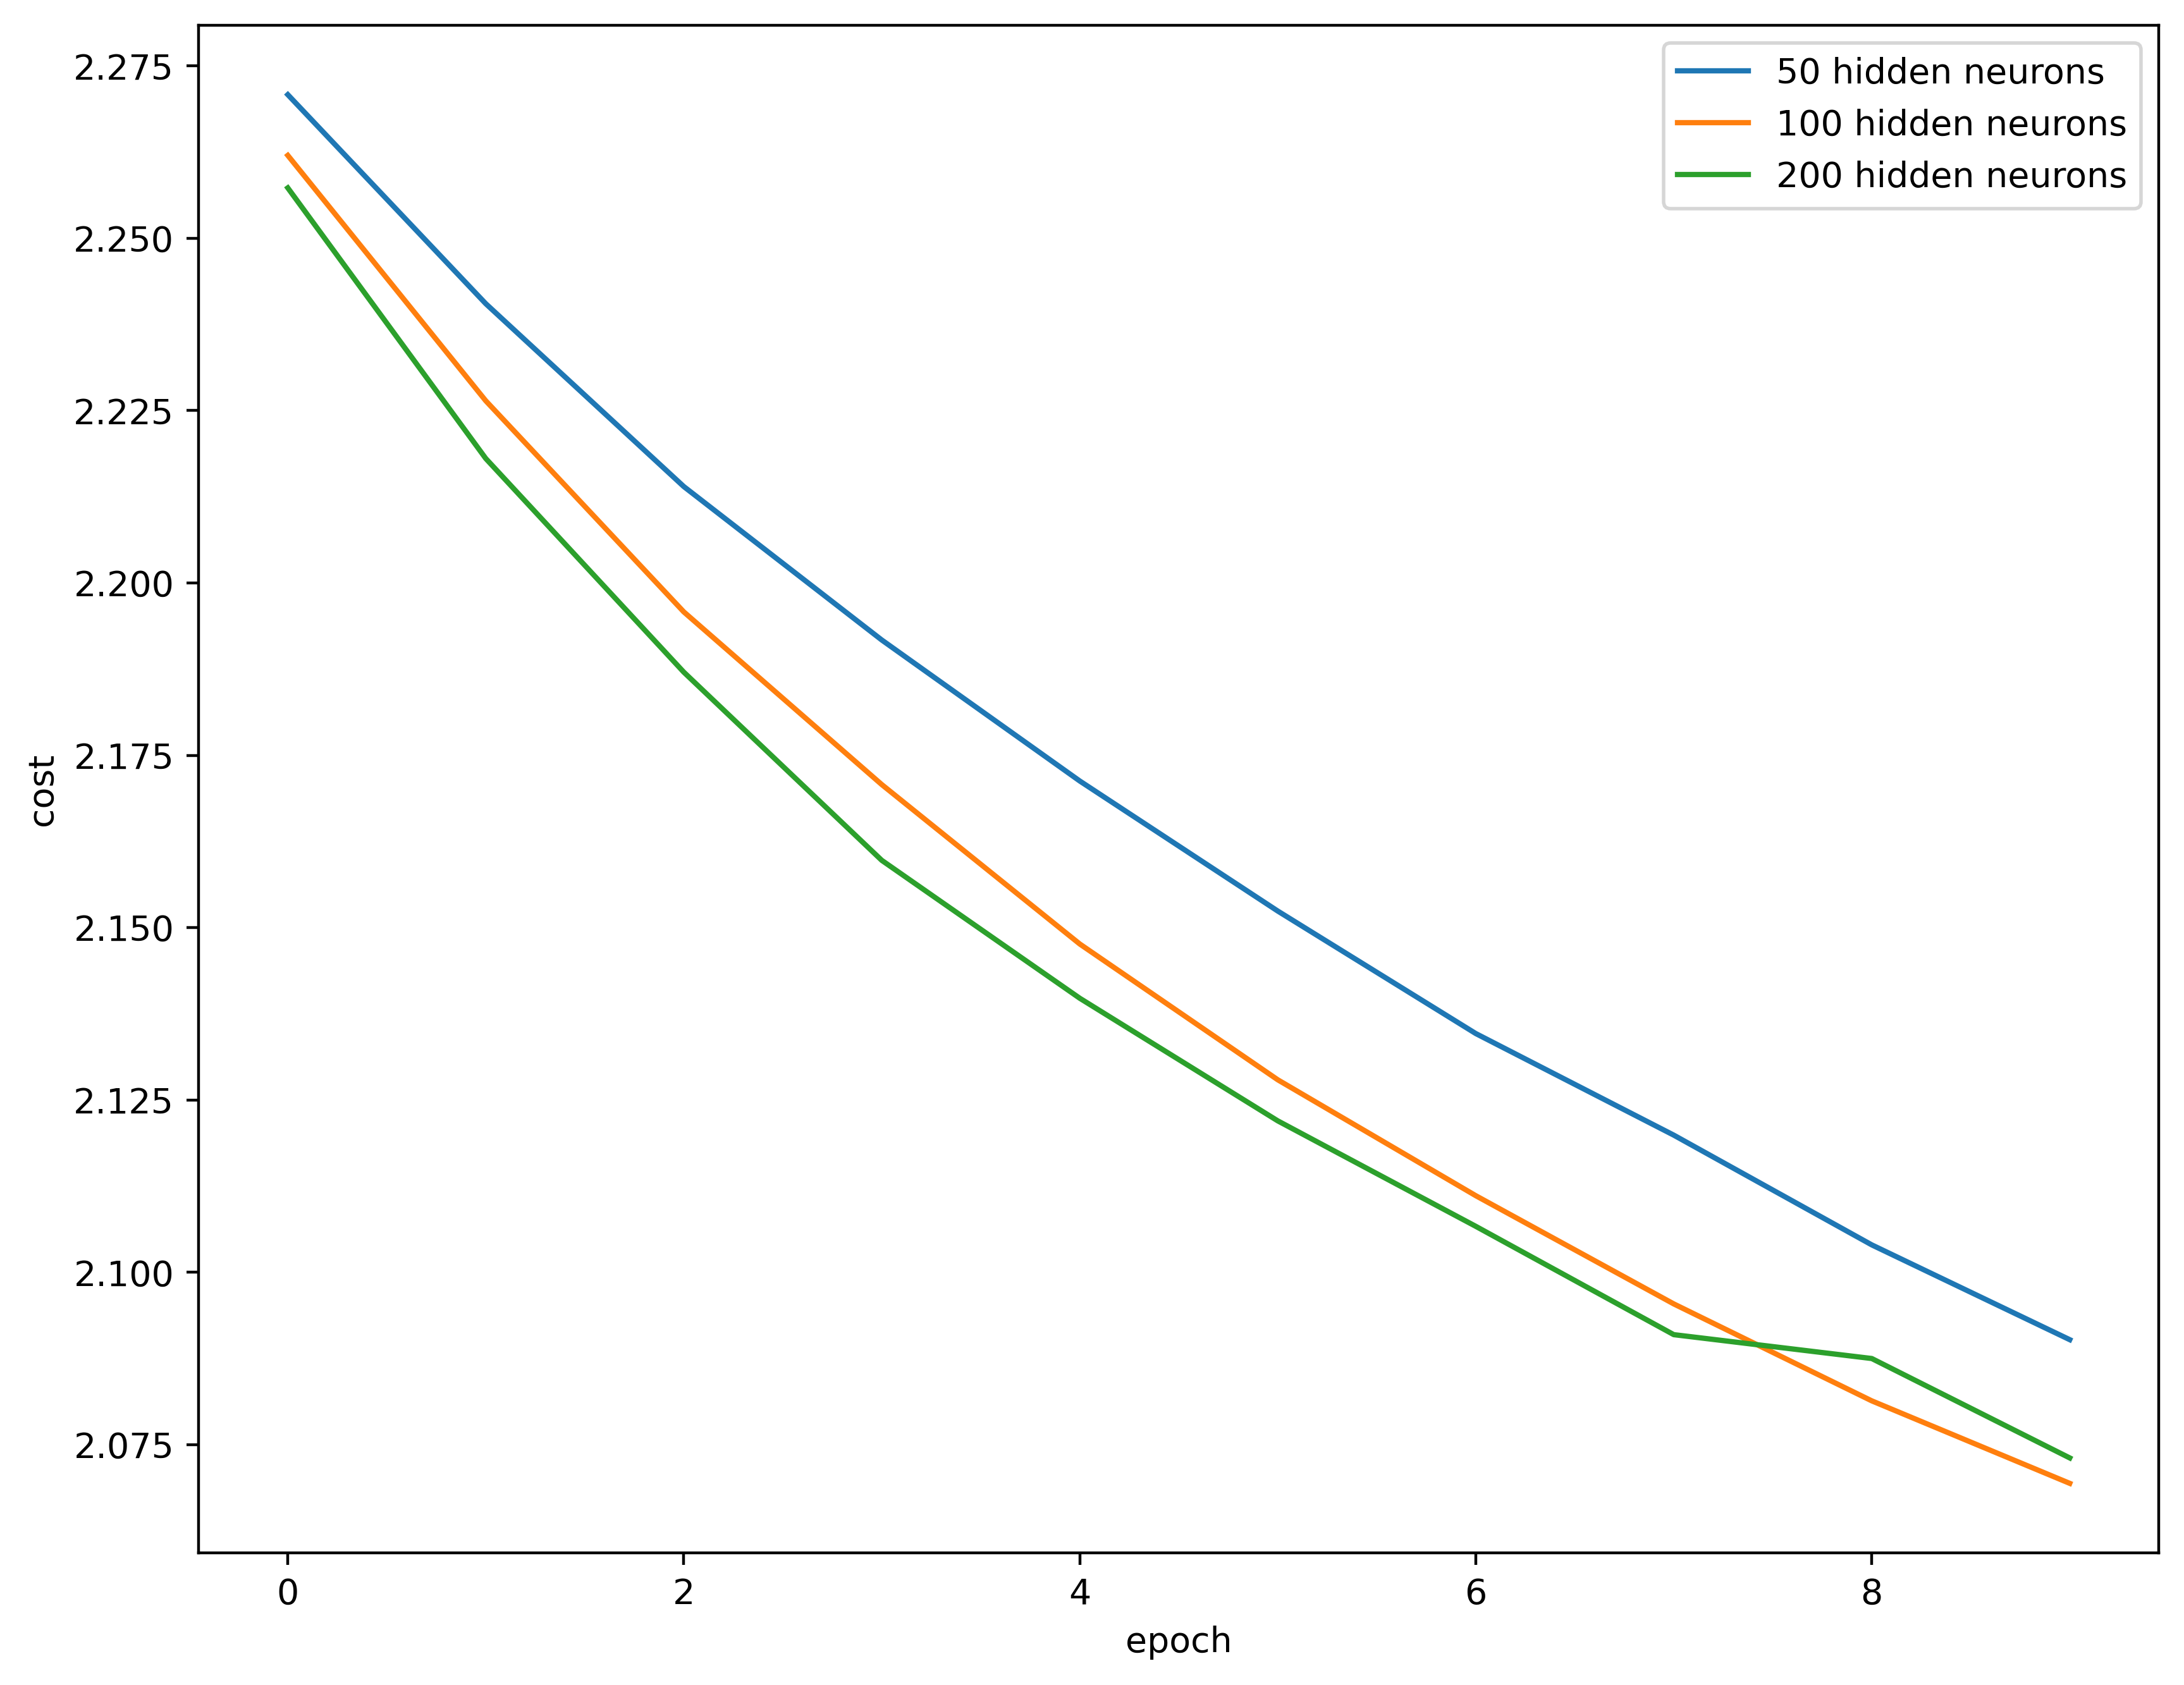

In [11]:
# Visualize results
epochs = np.arange(len(costs_0))
plt.figure(figsize=(10,8),dpi=400)
plt.plot(epochs, costs_0, label='50 hidden neurons')
plt.plot(epochs, costs_1, label='100 hidden neurons')
plt.plot(epochs, costs_2, label='200 hidden neurons')
plt.xlabel('epoch')
plt.ylabel('cost')
plt.legend(loc='best')
plt.savefig('figure_1.png')

## Đánh giá mô  hình
Xây dựng hàm test_nnet để sinh ra bộ kết quả tương ứng với từng mẫu dữ liệu đầu vào, bộ thứ i cho giá trị 1 nghĩa là model dự đoán đúng, cho giá trị 0 nghĩa là model dự đoán sai. 

In [28]:
#Test nnet
def test_nnet(Ws, X, Y):
    model_prob_Y = compute_nnet_outputs(Ws, X, False)
    check_Y = [np.argmax(model_prob_Y[isample]) == Y[isample][0] for isample in range(len(Y))]
    return check_Y

**Đánh giá dùng Accuracy**
Chọn accuracy vì đây là bộ dữ liệu cân bằng, số mẫu ở từng lớp là giống nhau, 6000 mẫu mỗi lớp. Bên cạnh đó, số mẫu mỗi lớp trên tổng số mẫu là nhỏ 6000/60000 nên việc dự đoán chính xác mẫu nào thuộc lớp nào sẽ rất thử thách. Vì vậy dùng accuracy là hiệu quả để đánh giá mô hình này.

In [30]:
#Evaluate
#hidden layer size [50]
print("Accuracy:")

test_res = test_nnet(W_0, test_X, test_Y)
accuracy = sum(test_res)/len(test_res)
print("    Hidden layer size [50]: ", accuracy)

test_res = test_nnet(W_1, test_X, test_Y)
accuracy = sum(test_res)/len(test_res)
print("    Hidden layer size [100]: ", accuracy)

test_res = test_nnet(W_2, test_X, test_Y)
accuracy = sum(test_res)/len(test_res)
print("    Hidden layer size [200]: ", accuracy)


Accuracy:
    Hidden layer size [50]:  0.2798
    Hidden layer size [100]:  0.2871
    Hidden layer size [200]:  0.2884
